# 大課題　タイタニック生存予測　ランダムフォレスト

タイタニック号は、20世紀初頭に建造された豪華客船である。

処女航海中の1912年4月14日深夜、北大西洋上で氷山に接触、翌日未明にかけて沈没した。犠牲者数は乗員乗客合わせて1,513人であり、当時世界最悪の海難事故であった。

今回はタイタニック号に乗っていた乗客データから生存するかどうかを予測する。

### データ取得

[ここ](https://www.kaggle.com/c/titanic/data)からtrain.csv、test.csvをダウンロードする。

### データ読み込み

In [1]:
# 必要モジュールの用意
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

#### データを確認する



In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


891データあり、欠損値があるカラムは下記の３つ
- Age(年齢)
- Cabin(客席)
- Embarked(乗船港）

またカテゴリーデータは下記の５つあり、手法によって数値データに置き換える必要がある。
- Name（名前）
- Sex（性別）
- Ticket（チケット）
- Cabin（客席）
- Embarked（乗船港）

### sample
sampleメソッドを使ってデータの中からランダムに抽出してデータを出力することができる。
時系列データなどが時間順に並んでいる場合はhead()やtail()で見るよりデータをよく理解することができる。


In [6]:
train_df.sample(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
233,234,1,3,"Asplund, Miss. Lillian Gertrud",female,5.0,4,2,347077,31.3875,NaN,S
524,525,0,3,"Kassem, Mr. Fared",male,NaN,0,0,2700,7.2292,NaN,C
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,B22,S
108,109,0,3,"Rekic, Mr. Tido",male,38.0,0,0,349249,7.8958,NaN,S
797,798,1,3,"Osman, Mrs. Mara",female,31.0,0,0,349244,8.6833,NaN,S
129,130,0,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,NaN,S
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S
203,204,0,3,"Youseff, Mr. Gerious",male,45.5,0,0,2628,7.2250,NaN,C
604,605,1,1,"Homer, Mr. Harry (""Mr E Haven"")",male,35.0,0,0,111426,26.5500,NaN,C
408,409,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,0,0,312992,7.7750,NaN,S


### 前処理について記述せよ

前処理とはデータ分析や機械学習のためにデータを扱いやすい形式にすること。

前処理を行うことでモデル学習が行えるようになったり、学習速度を早めたり、最終的な精度を高めることができる。

前処理は具体的には

1. 欠損値処理
1. カテゴリーデータを数値データへ置き換える
1. 特徴から新しい特徴を抽出する（ex 時間帯を朝、昼、夜に置き換える）
1. フィーチャースケーリング

などがあり、それぞれ下記のような効果がある。

1. 数値データを扱う手法を使う場合は必須の処理
1. 1.に同じ
1. よい特徴量を作ることで精度を高める。
1. パラメータの発散を防ぎ、学習速度を早める。



### 2/前処理について記述せよ

データを確認する際には前処理を意識して下記の点に着目してデータを分析する。

1. 欠損値がないか。欠損していないデータからどう処理するか（平均値を埋めるか、０をいれるか）
1. データの型を確認し、カテゴリーデータがあるか
1. フィーチャースケーリングするためにデータの分布を確認する。
    - データがガウス分布に従っているなら標準化
    - 一様分布なら正規化（RGB値など最大、最小が決まっているものなど）

### 前処理を行う

In [7]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    # チケット　名前　乗船港の特徴量は削除する
    df = drop_features(df)
    return df

train_df = transform_features(train_df)
test_df = transform_features(test_df)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [8]:
# 前処理２　カテゴリーデータを数値データに置き換える
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

train_df, test_df = encode_features(train_df, test_df)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


数値データに置き換わっていることが確認できた。


### 前処理の内容について記述せよ

上記の前処理のメソッドが何をおこなっているか、なぜ行うか

- **simplify_ages**
    - 年齢層に分けてカテゴリーデータに変換する。具体的な年齢より年齢層で判定するため。
- **simplify_cabins**
    - 客席番号を先頭位置文字に変換。番号は重要ではなく、先頭がグレードを示すのでそれだけ抽出して扱う。

- **simplify_fares**
    - 運賃を価格帯によって４段階に分ける。欠損値はUnkownにする。具体的な価格ではなくグレードで判定するため。


- **format_name**
    - ラストネームと敬称を抽出して新しい特徴量を作成する。敬称によってその人の年齢や既婚未婚が分かるため重要な特徴量となる。ラストネームを抽出したのはなぜか不明。

- **drop_features**
    - チケット番号、年齢、乗船港の列を削除する。生存するかどうかにチケット番号や年齢、どこで乗船したかは関係ないため省く。

- **encode_features**
    - カテゴリーデータを数値に置き換える処理。これによって数値データしか扱えない機械学習の手法でもカテゴリーデータを扱うことができる。


### モデル選択について記述せよ

今回は生存予測（survival  0(No) or 1(Yes）)を予測する２クラスの分類問題である。

分類問題に使用できそうなモデルとして次の４つが挙げられる。

1. ロジスティック回帰
    - 概要
        - 各特徴量への重み付けをする線形関数を用意し、その値をロジスティック関数に通すことで確率として出力するモデル。
    - メリット
        - データや特徴量が大きくても高速に動作する
        - 確率的勾配法の場合は局所解に捕まりづらい
        - 解釈が容易（パラメータの重みが重要度）
    - デメリット
        - 精度があまり出ない
        - 線形分離可能な問題に対応できない
        - フィーチャースケーリングやカテゴリデータの変換など前処理が必要（多重共線性や外れ値の処理も）
2. SVM
    - 概要
        - データを分類する境界面から一番近いデータをサポートベクトルとし、サポートベクトルと境界面との距離が大きいほど誤判定が起きづらいモデルとなることを利用したモデル。
    - メリット
        - データの特徴量数が多くなっても識別精度が高い
        - カーネル法により超次元空間に写像することで線形分離できない問題に対応できる（rbfカーネル）
        - ハイパーパラメータが少ない
    - デメリット
        - 説明性が低い
        - 学習データが増えると計算量が膨大
        - 多クラス分類するには工夫が必要（１対多分類法など）またパラメータも２クラスとは別もの
3. 決定木
    - 概要
        - 決定木とはデータをある条件で分類する枝のようなものを複数組み合わせて分割し、最終的にあるクラスに分類する手法。
    - メリット
        - 決定木として判別条件が出力できるので説明が用意
        - 目的変数、説明変数ともに、カテゴリ変数でも連続変数でも対応 
        - 説明変数の選択が必要ない（モデルでやってくれる）
        - 非線形構造も表現可能
    - デメリット
        - チューニングしてもそれほど精度が出ない場合がある
        - 深さを調整しないと過学習しやすい
        - モデルとしてのロバスト性（頑健性）が弱く、適切でない説明変数が入ると、その変数にモデル全体が引っ張られてしまう
4. ランダムフォレスト
    - 概要 
        - 決定木を複数作成し、その平均を取るなどして結果を一つにまとめるアンサンブル学習。
    - メリット
        - 特徴量のスケーリングが必要ない 
        - 高精度で表現力が高い
        - データが多くても高速に動く
        - モデル選択で「まずやってみる」のに便利
    - デメリット
        - パラメータが多い
        - データや説明変数をランダム抽出して学習するのでデータが少なすぎるとうまく学習できない。
        - 決定木の数が多くなると計算量が多くなる

### モデル選択の基準

- 問題（回帰 or 分類）と訓練データに答え（ラベル）があるか
- 訓練データ量と特徴量
- 精度はどの程度必要か
- 結果をどう使うか（精度が出てもアクションを起こせるか？）
    - どの特徴量が結果に寄与するか説明がし易いほうがアクションを起こしやすい

### モデル選択におけるデータ可視化

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

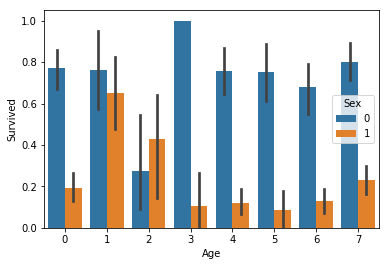

In [10]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=train_df);

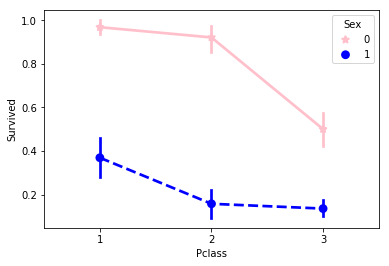

In [11]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=train_df,
              palette={1: "blue", 0: "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

### データ可視化の結果について考察せよ

バープロットから子供層以外は女性の方が生存率が高いことが分かる。
また、女性の方が生存率が高く、ファーストクラスのほうが生存率が高い。

以上の考察結果からモデル選択を考える場合、性別とクラスをあわせた特徴量を追加するとより精度が出る可能性がある。

### データセットの分割

下記のコードで訓練データを学習データ、テストデータの割合8:2で分割する。

In [12]:
from sklearn.model_selection import train_test_split

X = train_df.drop(['Survived', 'PassengerId'], axis=1)
y = train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0,
)

print("X_train : {}".format(X_train.shape))
print("X_test : {}".format(X_test.shape))
print("y_train : {}".format(y_train.shape))
print("y_test : {}".format(y_test.shape))

X_train : (712, 9)
X_test : (179, 9)
y_train : (712,)
y_test : (179,)


８：２で分割できていることが確認できた。

### ランダムフォレストについて記述せよ

決定木とはデータをある条件で分類する枝のようなものを複数組み合わせて分割し、最終的にあるクラスに分類する手法。

説明がしやすい反面、他手法に比べ精度が出づらい、過学習しやすいといった欠点がある。

このデメリットの解消を目指したものが**ランダムフォレスト**になります。

ランダムフォレストは決定木を複数作成し、その平均を取るなどして結果を一つにまとめる**アンサンブル学習**になります。

- メリット
    - 特徴量のスケーリングが必要ない 
    - 高精度で表現力が高い
    - データが多くても高速に動く
    - 特徴量の重要度を出力できる
- デメリット
    - パラメータが多い
    - データや説明変数をランダム抽出して学習するのでデータが少なすぎるとうまく学習できない。
    - 決定木の数が多くなると計算量が多くなる

今回の目的はデータから生死を予測し、同じ事故を起こさない、また起きた際にどう対処すべきかを考えることであり、どの特徴量が重要かを出力できること、パラメータチューニングやフィーチャースケーリングに時間をかけずにモデルを作成できるため、ランダムフォレストがモデルとして適していると判断できます。

### 学習

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(max_depth= 2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### accuracyを求めよ

In [29]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8156424581005587

### 精度を高める

今の時点で75%を超えているがさらに
ハイパーパラメータチューニングを行って精度を上げていく。

### ハイパーパラメータについて

ハイパーパラメータとはモデル学習では変更されない設定値。ハイパーパラメータを変更することで学習の挙動や評価方法が変わる。

ランダムフォレストにおけるハイパーパラメータは下記のようなものがある。

- n_estimators : 決定木の数 デフォルト１０ 　大きいと性能が良くなるが時間がかかる
- max_depth: 決定木の深さ　指定しないとすべての葉っぱが完全に分類できるか、min_sample_splitで指定したサンプル数になるまで探索する。 大きくすると過学習気味に、小さくすると未学習になりやすい。
- max_feature: 分割するときに考慮する特徴量の数。　大きいと性能が良くなるが時間がかかる。
- random_state: 乱数のシード値を決める。同じ値を設定すると同じ乱数を使うのでモデル間の性能比較する際に同じ値を用いる

### チューニング



In [15]:
n_estimators = [4, 6, 9]
max_features = ['log2', 'sqrt','auto']
criterion = ['entropy', 'gini']
max_depth = [2, 3, 5, 10]
min_samples_split = [2, 3, 5]
min_samples_leaf = [1,5,8]

best_score = 0

for e in n_estimators:
    for max_f in max_features:
        for c in criterion:
            for max_d in max_depth:
                for min_s_split in min_samples_split:
                    for min_s_leaf in min_samples_leaf:
                        clf = RandomForestClassifier(n_estimators=e,
                                                    max_features=max_f,
                                                    criterion=c,
                                                    max_depth=max_d,
                                                    min_samples_split=min_s_split,
                                                    min_samples_leaf=min_s_leaf,
                                                    random_state=0)
                        clf.fit(X_train, y_train) 
                        y_pred = clf.predict(X_test)
                        score = accuracy_score(y_test, y_pred)
                        if (score > best_score):
                            best_score = score
                            best_n_estimators= e
                            best_max_features=max_f
                            best_criterion=c
                            best_max_depth=max_d
                            best_min_samples_split=min_s_split
                            best_min_samples_leaf=min_s_leaf

print('best_accuracy : {}'.format(best_score))
print('best_n_estimators : {}'.format(best_n_estimators))
print('best_max_features : {}'.format(best_max_features))
print('best_criterion : {}'.format(best_criterion))
print('best_max_depth : {}'.format(best_max_depth))
print('best_min_samples_split : {}'.format( best_min_samples_split))
print('best_min_samples_leaf : {}'.format( best_min_samples_leaf))

best_accuracy : 0.8547486033519553
best_n_estimators : 4
best_max_features : log2
best_criterion : entropy
best_max_depth : 3
best_min_samples_split : 2
best_min_samples_leaf : 5


チューニングの結果上記のパラメータが良い

In [17]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [4, 6, 9],
    'max_features': ['log2', 'sqrt','auto'],
    'criterion': ['entropy', 'gini'],
    'max_depth': [2, 3, 5, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1,5,8]
}
clf = RandomForestClassifier()
cv =GridSearchCV(clf, params, cv = 5)
                 #, scoring= 'recall')
                                                    #random_state=0)
cv.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [4, 6, 9], 'max_features': ['log2', 'sqrt', 'auto'], 'criterion': ['entropy', 'gini'], 'max_depth': [2, 3, 5, 10], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 5, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
cv.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 9}

### 検証について記述せよ

検証とは学習したモデルが過学習していないか、汎化性能が下がっていないか確認する作業になる。

主な検証方法として、
- ホールド・アウト法 : 訓練データを半々に分ける
    - 訓練データが多いと過学習ぎみ、　検証データを増やすと未学習になる可能性がある。
- k分割法：　訓練データをk分割してk回計測する。
- ジャックナイフ法：１つのデータをテストデータ、他を学習データにするK分割法。データが少ないときに用いられる。

検証は特定のデータのみに精度が出ていないかを確認するもので問題の性質によってさまざまな評価基準が用いられる。

例：検索ではprecision、病気の判定ではrecallが重視される

### KFoldについて記述せよ

KFold(K-分割交差検証）とは訓練データをK個に分け、K回検証を行う方法。

大きすぎるとクラス分けされたあるクラスのデータが極端に少ないとうまく機能しない上、
検証に時間がかかるためデータセットの大きさとクラスの偏りを考慮してKの値は3-10程度の範囲で考える。
分割した一つをテストデータとして、残りを訓練データとして検証する。

K分割交差検証を行うと結果としてK回の平均した精度と標準偏差が出力される。

### KFoldを実施する

In [19]:
np.array(X)[np.array([1,2,4])]

array([[  1,   0,   0,   1,   0,   3,   2, 182,  20],
       [  3,   0,   7,   0,   0,   0,   7, 329,  16],
       [  3,   1,   7,   0,   0,   1,   7,  15,  19]])

In [22]:
# 必要なライブラリのインポート
from sklearn.model_selection import KFold
import math
# 動かすパラメータを明示的に表示、今回は決定木の数を変えてみる
params = {'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 9}

kf = KFold(n_splits=4)
kf.get_n_splits(train_df)
print(kf) 

accuracy = []
for train_index, test_index in kf.split(X_train):
    #print("TRAIN:", train_index, "TEST:", test_index)
    feature_train, feature_test = np.array(X_train)[train_index], np.array(X_train)[test_index]
    target_train, target_test = np.array(y_train)[train_index], np.array(y_train)[test_index]
    clf = RandomForestClassifier(
        criterion='entropy',
        max_depth=10,
        max_features='log2',
        min_samples_leaf=5,
        min_samples_split=5,
        n_estimators=9)
    clf.fit(feature_train, target_train)
    target_pred = clf.predict(feature_test)
    accuracy.append(accuracy_score(target_test, target_pred))

accuracy = np.array(accuracy)

print('accuracy_mean is {}'.format(np.mean(accuracy)))
print('accuracy_std is {}'.format(np.std(accuracy)))

KFold(n_splits=4, random_state=None, shuffle=False)
accuracy_mean is 0.8230337078651685
accuracy_std is 0.012244098156013112


### Kfoldの結果を確認する

上記の結果、精度82%、標準偏差の値も低いため成功となる。

### どの特徴量が重要であったかを調査する

In [23]:
clf = RandomForestClassifier(
        criterion='entropy',
        max_depth=10,
        max_features='log2',
        min_samples_leaf=5,
        min_samples_split=5,
        n_estimators=9)
clf.fit(X_train, y_train)
clf.feature_importances_

array([0.09957929, 0.33444807, 0.06190322, 0.04685339, 0.03090881,
       0.06339435, 0.05878335, 0.14804925, 0.15608028])

/Users/kzfm/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


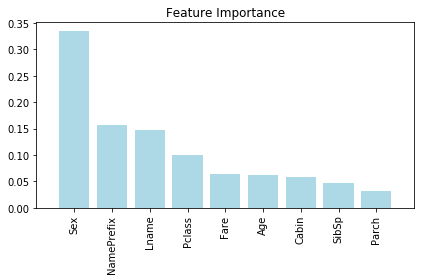

In [27]:
#特徴量の重要度
feature = clf.feature_importances_

#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),
             'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)
f3 = f2.ix[:, 'number']

#特徴量の名前
label = X_train.columns[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

# for i in range(len(feature)):
#     print str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]])

plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()

グラフの通り、性別が最も重要度が高く、敬称、名字、クラスと続くことが分かる。